In [1]:
import os
import pandas as pd
os.chdir(r'C:\...')
os.getcwd()

xl = pd.ExcelFile("....xlsx")
df1 = xl.parse(xl.sheet_names[0], skiprows=0)


In [2]:
df1['Amt'] = df1['Amt'].fillna(0)
df1=df1.sort_values('Date').reset_index(drop=True)
df1=df1.set_index(pd.DatetimeIndex(df1['Date'])) 

In [3]:
df1['NonBusDay'] = (df1['BankHoliday'] + df1['Weekend'])*10
df1['BusDay'] = df1['WeekDay']
df1['BusDay'][df1['WeekDay']>5] =0

df2 = df1[['BusDay', 'NonBusDay', 'Amt']]

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [5]:
df2.shape

(182, 3)

In [6]:
print('Data Length:', len(df2))
print('number of rows to truncate:', len(df2)%7)
print("Total number of weeks:", len(df2)//7)

Data Length: 182
number of rows to truncate: 0
Total number of weeks: 26


In [7]:
lengthinWeeks=len(df2)//7
valWeeks=4
testWeeks=4
test_index=(lengthinWeeks-testWeeks)*7 # taking the last 162 days to forecast on
val_index=(lengthinWeeks-testWeeks-valWeeks)*7

print('total {0}, validation set from {1} to {2}, test set from {3} to {4}'.format(lengthinWeeks*7, \
                                                                                   val_index,test_index, \
                                                                                   test_index, lengthinWeeks*7))

total 182, validation set from 126 to 154, test set from 154 to 182


In [8]:
from sklearn import preprocessing
import numpy as np
y_scaled = preprocessing.scale(df2['Amt'].values)

TrainMean = np.mean(df2['Amt'].values)
TrainSd = np.std(df2['Amt'].values)

def inverseScale(y_scaled, TrainMean, TrainSd):
    return y_scaled*TrainSd + TrainMean


In [9]:
df2['NormAmt'] = y_scaled

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [10]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
sns.lineplot(data=df2, x=df2.index,y="NormAmt")
plt.xticks(rotation=90)
#plt.show();

(array([ 736695.,  736726.,  736754.,  736785.,  736815.,  736846.,  736876.]),
 <a list of 7 Text xticklabel objects>)

In [11]:
df3 = df2[['BusDay', 'NonBusDay', 'NormAmt']]

In [12]:
# We're going to call that the casual observer model as cashflow of a given day is the same as the same weekday of previous week. 
# This model is lazy and assumes the cash flow is the same value it was 7 days ago.

def casual_observer(series,step):
    ypred=[series.iloc[i-step] for i in range(step,len(series))]
    actual=[series.iloc[i+step] for i in range(len(series)-step)]
    return (np.asarray(ypred).reshape(-1,1),np.asarray(actual).reshape(-1,1))

In [13]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler 
import numpy as np 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_pacf;

step = 7
temp_naive,actual=casual_observer(df3['NormAmt'].iloc[val_index:test_index],step)
casual_error=mean_absolute_error(actual,temp_naive)
print('simple prediction Error:',casual_error)

simple prediction Error: 1.27915025309


In [14]:
def seq_prep(df,y_var,hist,frcst,frcst_step,val,test):
    '''
    inputs:
    df: DataFrame that contains X, y variables
    y_var: y_var label, this will be a string
    hist: is an integer for the number of weeks lag
    frcst: is an integer for the number of weeks forward for forecast
    frcst_step: this is an integer for how many days to forecast   
    Val: is the index for Validation
    test: is the index for test
    
    outputs:
    train_seqx: List of Arrays containing the training X input. The shape per array should be (7*hist,number of columns in df)
    train_seqy: List of Arrays containing the training y (label), the shape per array should be (7*fore,)
    val_seqx: List of Arrays containing the valdiation X input. The shape per array should be (7*hist,number of columns in df)
    val_seqy: List of Arrays containing the validation y (label), the shape per array should be (7*fore,)
    test_seqx: List of Arrays containing the test X input. The shape per array should be (7*hist,number of columns in df)
    test_seqy: List of Arrays containing the test y (label), the shape per array should be (7*fore,)
    '''
    train_seqx=[]
    train_seqy=[]
    val_seqx=[]
    val_seqy=[]
    test_seqx=[]
    test_seqy=[]
    train_df=df.iloc[:val,:]
    val_df=df.iloc[val:test,:]
    test_df=df.iloc[test:,:]
    train_x_arr=train_df.values
    train_y_arr=train_df[y_var].values
    val_x_arr=val_df.values
    val_y_arr=val_df[y_var].values
    test_x_arr=test_df.values
    test_y_arr=test_df[y_var].values
    hist_seq=7*hist # turning history into 24 hour x number of days vector
    fore_seq=7*frcst
    seq_len=(hist_seq+fore_seq)
    
    for i in range(len(train_y_arr)):
        if i+seq_len<len(train_y_arr):
            train_seqx.append(train_x_arr[i:i+hist_seq,:])
            train_seqy.append(train_y_arr[i+hist_seq:i+seq_len][:frcst_step])         
       
        else:
            val_index_add=i     
            break
            
            
    val_x_arr=np.insert(val_x_arr,0,train_x_arr[val_index_add:,:],axis=0)
    val_y_arr=np.insert(val_y_arr,0,train_y_arr[val_index_add:],axis=0)
    for i in range(len(val_y_arr)):
        if i+seq_len<len(val_y_arr):
            val_seqx.append(val_x_arr[i:i+hist_seq,:])
            val_seqy.append(val_y_arr[i+hist_seq:i+seq_len][:frcst_step])       
       
        else:
            test_index_add=i  
            break
             
    test_x_arr=np.insert(test_x_arr,0,val_x_arr[test_index_add:,:],axis=0)
    test_y_arr=np.insert(test_y_arr,0,val_y_arr[test_index_add:],axis=0)
    for i in range(len(test_y_arr)):
        if i+seq_len<len(test_y_arr):
            test_seqx.append(test_x_arr[i:i+hist_seq,:])
            test_seqy.append(test_y_arr[i+hist_seq:i+seq_len][:frcst_step])   
    
            
    return train_seqx,train_seqy,val_seqx,val_seqy,test_seqx,test_seqy

In [15]:
train_X_list, train_y_list,val_X_list, val_y_list,test_X_list, test_y_list=seq_prep(df3,
                                                                                    "NormAmt",4,1,1,val_index,test_index)

In [16]:
print('Shape of input sequence:',train_X_list[0].shape)
print('Shape of output sequence:',train_y_list[0].shape)

# input x shape: 28 x 4
#      4 weeks * 7 days = 28
#      3 variables

Shape of input sequence: (28, 3)
Shape of output sequence: (1,)


In [17]:
from keras.preprocessing import sequence

Using TensorFlow backend.


In [18]:
'''Defining the sequence lengths for both input and output'''
X_seqlen=train_X_list[0].shape[0]
y_seqlen=train_y_list[0].shape[0]

In [19]:
print('X_seqlen is ', X_seqlen)
print('y_seqlen is ', y_seqlen)

X_seqlen is  28
y_seqlen is  1


In [20]:
'''
pad_sequences function is a very versatile function. it allows us to handle cases 
of uneven sequence length by padding or truncating to a specificed length.
Default pad value is 0, but user can apply any number or pass an impute into it

'''
train_X_seq = sequence.pad_sequences(train_X_list, dtype='float32', maxlen=X_seqlen, padding='post',truncating='post')
train_y_seq = sequence.pad_sequences(train_y_list,dtype='float32',maxlen=y_seqlen, padding='post',truncating='post')
val_X_seq = sequence.pad_sequences(val_X_list, dtype='float32', maxlen=X_seqlen, padding='post',truncating='post')
val_y_seq = sequence.pad_sequences(val_y_list,dtype='float32',maxlen=y_seqlen, padding='post',truncating='post')
test_X_seq = sequence.pad_sequences(test_X_list, dtype='float32', maxlen=X_seqlen, padding='post',truncating='post')
test_y_seq = sequence.pad_sequences(test_y_list,dtype='float32',maxlen=y_seqlen, padding='post',truncating='post')

In [21]:
'''WE got our Tensors'''
print('X shape:', train_X_seq.shape)
print('y shape:',train_y_seq.shape)

X shape: (91, 28, 3)
y shape: (91, 1)


In [22]:
'''before padding'''
print('X shape:', len(train_X_list), train_X_list[0].shape)
print('y shape:',len(train_y_list),train_y_list[0].shape)

X shape: 91 (28, 3)
y shape: 91 (1,)


In [23]:
BATCH_SIZE =91
NUM_TIMESTEPS=train_X_seq.shape[1]   #28 days
features=train_X_seq.shape[2]        # number of variables
output=train_y_seq.shape[1]

In [24]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from keras.optimizers import RMSprop

In [25]:
model = Sequential()
'''The input to an LSTM layer has to be 3D tensor. The default LSTM layer output is 2D '''
model.add(LSTM(32, input_shape=(NUM_TIMESTEPS,features )))## The shape of each input sample is defined in 1st layer only
model.add(Dense(output))
model.compile(optimizer=RMSprop(), loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4608      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [26]:
history=model.fit(train_X_seq,train_y_seq,epochs=500,shuffle=False,batch_size=BATCH_SIZE,validation_data=(val_X_seq,val_y_seq))

Train on 91 samples, validate on 28 samples
Epoch 1/500
91/91 [==============================] - 1s 8ms/step - loss: 0.5780 - val_loss: 0.9411
Epoch 2/500
91/91 [==============================] - 0s 132us/step - loss: 0.5416 - val_loss: 0.9291
Epoch 3/500
91/91 [==============================] - 0s 143us/step - loss: 0.5305 - val_loss: 0.9172
Epoch 4/500
91/91 [==============================] - 0s 165us/step - loss: 0.5209 - val_loss: 0.9138
Epoch 5/500
91/91 [==============================] - 0s 165us/step - loss: 0.5135 - val_loss: 0.9097
Epoch 6/500
91/91 [==============================] - 0s 154us/step - loss: 0.5073 - val_loss: 0.8998
Epoch 7/500
91/91 [==============================] - 0s 171us/step - loss: 0.5014 - val_loss: 0.8954
Epoch 8/500
91/91 [==============================] - 0s 176us/step - loss: 0.4961 - val_loss: 0.8838
Epoch 9/500
91/91 [==============================] - 0s 154us/step - loss: 0.4904 - val_loss: 0.8720
Epoch 10/500
91/91 [=============================

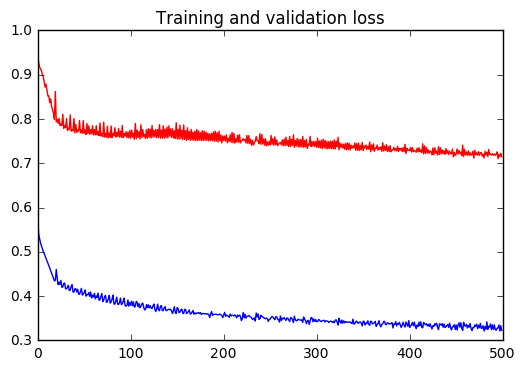

In [28]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_loss))

plt.figure()

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
#plt.legend()

plt.show()

In [29]:
% time mean_absolute_error(val_y_seq,model.predict(val_X_seq))

Wall time: 45.2 ms


0.71539557

In [30]:
% time mean_absolute_error(test_y_seq,model.predict(test_X_seq))

Wall time: 2.51 ms


0.63634777

In [32]:
train_actual =inverseScale(train_y_seq, TrainMean, TrainSd)
train_Pred =inverseScale(model.predict(train_X_seq), TrainMean, TrainSd)
days = range(len(train_actual))

plt.figure()

plt.plot(days, train_actual, 'b', label='Actual')
plt.plot(days, train_Pred, 'r', label='Pred')
plt.title('Training Set Prediction')
plt.legend()
#plt.show()

In [33]:
val_actual =inverseScale(val_y_seq, TrainMean, TrainSd)
val_Pred =inverseScale(model.predict(val_X_seq), TrainMean, TrainSd)
days = range(len(val_actual))

plt.figure()

plt.plot(days, val_actual, 'b', label='Actual')
plt.plot(days, val_Pred, 'r', label='Pred')
plt.title('Validation Set Prediction')
plt.legend()
#plt.show()

In [34]:
test_actual =inverseScale(test_y_seq, TrainMean, TrainSd)
test_Pred =inverseScale(model.predict(test_X_seq), TrainMean, TrainSd)
days = range(len(test_actual))

plt.figure()

plt.plot(days, test_actual, 'b', label='Actual')
plt.plot(days, test_Pred, 'r', label='Pred')
plt.title('Test Set Prediction')
plt.legend(loc=2)
#plt.show()